In [1]:
import cv2
from PIL import Image
from IPython.display import display
import imutils
from scipy import ndimage


image=cv2.imread(r'/mnt/c/Users/yamshee.fatima/Desktop/image & OCR/watershed_coins_01.jpg')

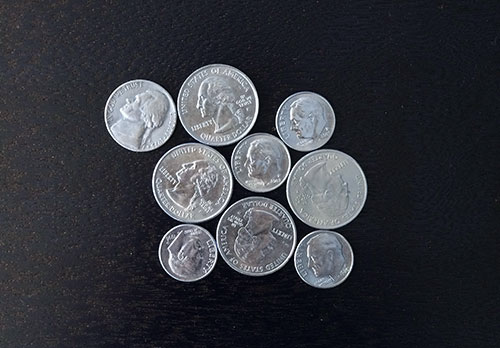

In [2]:
display(Image.fromarray(image))

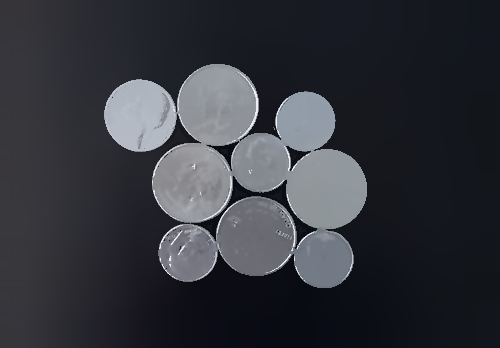

In [3]:
#load the image and perform pyramid mean shift filtering to aid the thresholding step
shifted = cv2.pyrMeanShiftFiltering(image, 25, 52)
display(Image.fromarray(shifted))

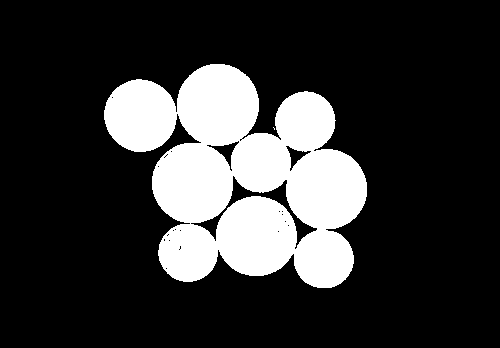

In [4]:
# convert the mean shift image to grayscale, then apply Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
display(Image.fromarray(thresh))

In [5]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [6]:
# loop over the contours
for (i, c) in enumerate(cnts):
    # draw the contour
    ((x, y), _) = cv2.minEnclosingCircle(c)
    cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

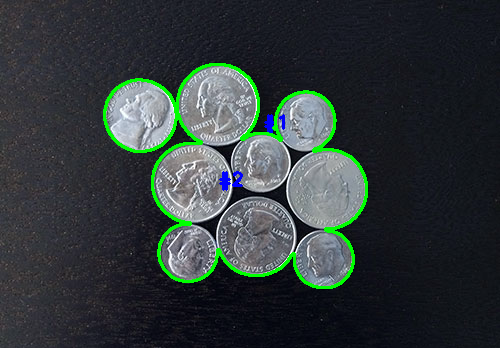

In [7]:
display(Image.fromarray(image))

#watershed Algo usage

In [13]:
import skimage
import numpy as np
from skimage.feature import peak_local_max
from skimage.morphology import watershed

In [14]:
# compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)
 
# perform a connected component analysis on the local peaks, using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 9 unique segments found


In [15]:
# loop over the unique labels returned by the Watershed algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background' so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
 
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

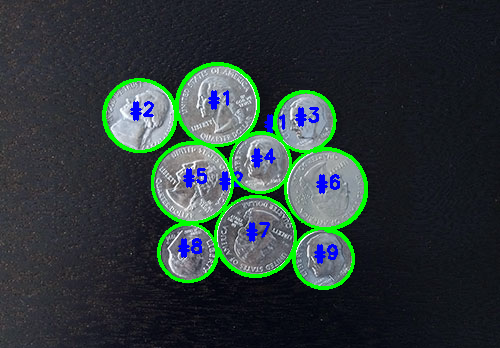

In [16]:
display(Image.fromarray(image))